<font size="5" face="serif">I use the <span style="color:blue">Keras</span> package to fetch the mnist dataset, but you can also get it from a variety of sources.</font>

In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
(Train_Imgs, Train_Labels), (Test_Imgs, Test_Labels) = mnist.load_data()
Train_Imgs=Train_Imgs/255
Test_Imgs=Test_Imgs/255

The train data set contains 60000 images with the size of 28 * 28.
The test data set contains 10000 images with the size of 28 * 28.
Here are some sample data point:



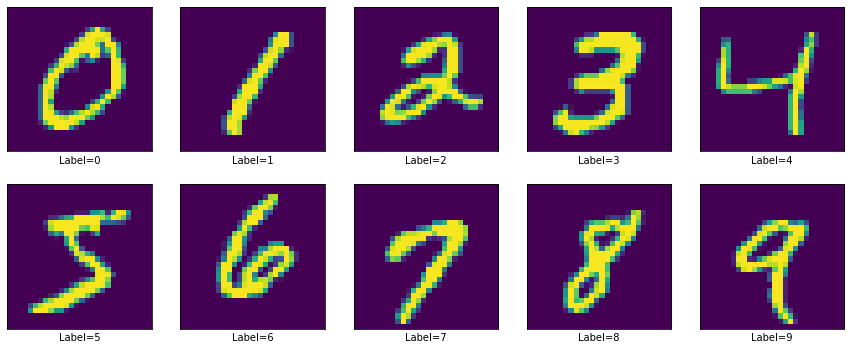

In [2]:
print("The train data set contains {} images with the size of {} * {}.".format(*Train_Imgs.shape))
print("The test data set contains {} images with the size of {} * {}.".format(*Test_Imgs.shape))
print("Here are some sample data point:\n")
f, axes = plt.subplots(2, 5, figsize=(15, 6))
Sample_Indexes=[np.where(Train_Labels==i)[0][0] for i in range(10)]
for i in range(2):
    for j in range(5):
        axes[i,j].imshow(Train_Imgs[Sample_Indexes[i*5+j]])
        axes[i,j].grid(False)
        axes[i,j].set(xlabel="Label={}".format(i*5+j))
        axes[i,j].set_yticklabels([])
        axes[i,j].set_xticklabels([])
        axes[i,j].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, left=False)

In [3]:
Train_Imgs=Train_Imgs.reshape(-1,28*28)
Test_Imgs=Test_Imgs.reshape(-1,28*28)
Train_Imgs=np.concatenate((Train_Imgs,Train_Labels.reshape(-1,1)),axis=1)
Test_Imgs=np.concatenate((Test_Imgs,Test_Labels.reshape(-1,1)),axis=1)


In [4]:
import pyspark
conf=pyspark.SparkConf().setMaster("local[1]").setAppName("Mnist_Logistic")\
                        .set("spark.sql.execution.arrow.enabled", "true")\
                        .set('spark.executor.memory', '4g')\
                        .set("spark.driver.memory","4g")
sc=pyspark.SparkContext(conf=conf)
sqlsess=pyspark.sql.SparkSession(sc)

In [5]:
from pyspark.ml.linalg import DenseVector
rdd_train=sc.parallelize(Train_Imgs).map(lambda x: (int(x[-1]),DenseVector(x[:len(x)-1])))
Data_Frame_train = sqlsess.createDataFrame(rdd_train,schema=["label", "features"])
rdd_test=sc.parallelize(Test_Imgs).map(lambda x: (int(x[-1]),DenseVector(x[:len(x)-1])))
Data_Frame_test = sqlsess.createDataFrame(rdd_test,schema=["label", "features"])

In [6]:
from pyspark.ml.classification import LogisticRegression
model_Logistic=LogisticRegression()
fitted_model=model_Logistic.fit(Data_Frame_train)

In [7]:
pred=fitted_model.transform(Data_Frame_test).select("label", "prediction").toPandas()

In [8]:
from sklearn.metrics import confusion_matrix as CM
cm_log=CM(y_true=pred["label"],y_pred=pred["prediction"])
cm_log=cm_log/cm_log.sum(axis=1)[:,None]


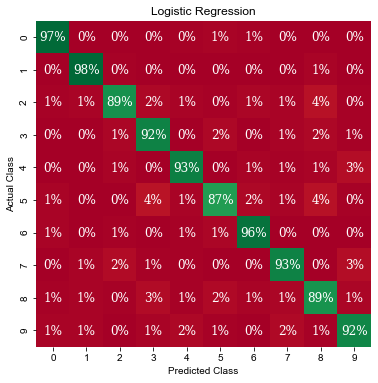

In [9]:
import seaborn as sns
from sklearn.metrics import accuracy_score,confusion_matrix

f, ax = plt.subplots(1,1, figsize=(6, 6))

sns.set(font="serif",font_scale=1)
sns.heatmap(cm_log,cmap="RdYlGn",annot=True,fmt='.0%',cbar=False,ax=ax);
ax.set_xlabel('Predicted Class');
ax.set_ylabel('Actual Class');
ax.set_title('Logistic Regression');